In [1]:
import pandas as pd
import numpy as np
import requests
import io
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, MonthLocator

In [2]:
url_1 = 'https://api.covid19india.org/csv/latest/states.csv'

In [3]:
response = requests.get(url_1).content

In [4]:
df = pd.read_csv(io.StringIO(response.decode('utf-8')))
India = df[df['State'] == 'India'].copy()
India['Date'] = pd.to_datetime(India['Date'])
India = India.sort_values(['Date']).reset_index(drop = True)


In [5]:
India['Daily Count'] = India['Confirmed'].diff()
India['Death Count'] = India['Deceased'].diff()
India['Recovery Count'] = India['Recovered'].diff()

In [6]:
def updateAnnot(bar):
    x = bar.get_x()
    y = bar.get_y()+bar.get_height()
    annot.xy = (x - 17, y + 2000)
    
    conf = India['Date'][India['Daily Count'] == bar.get_height()]
    reco = India['Recovery Count'][India['Daily Count'] == bar.get_height()]
    dead = India['Death Count'][India['Daily Count'] == bar.get_height()]
    
    text = "{}\nConfirmed : {:,.0f}\nRecovered : {:,.0f}\nDeath : {:,.0f}".format(conf.tolist()[0].date(), bar.get_height(), reco.tolist()[0], dead.tolist()[0])
    annot.set_text(text)
    annot.get_bbox_patch().set_alpha(1)
    
def mouseMove(event):
    vis = annot.get_visible()
    if event.inaxes == plt.gca():
        for bar in bars:
            cont, ind= bar.contains(event)
            if cont:
                updateAnnot(bar)
                annot.set_visible(True)
                plt.gcf().canvas.draw_idle()
                return
    if vis:
        annot.set_visible(False)
        plt.gcf().canvas.draw_idle()

<IPython.core.display.Javascript object>


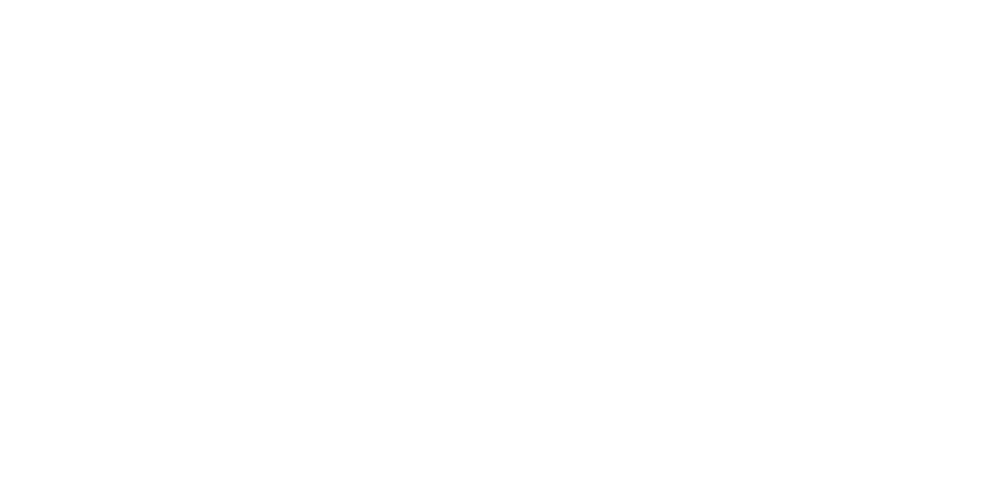

In [7]:
%matplotlib notebook
pd.plotting.register_matplotlib_converters()
plt.figure(figsize = (8, 4))
bars = plt.bar(India['Date'], India['Daily Count'], width = 0.75, color = 'blue', label = 'Confirmed', alpha = 0.7)
plt.bar(India['Date'], India['Recovery Count'], width = 0.75, color = 'green', label = 'Recovered', alpha = 0.75)
plt.bar(India['Date'], India['Death Count'], width = 0.75, color = 'red', label = 'Death', alpha = 0.9)

plt.legend(loc = 2, shadow = 0.5)

months = MonthLocator()
monthsFmt = DateFormatter("%b' %d")
plt.gca().xaxis.set_major_locator(months)
plt.gca().xaxis.set_major_formatter(monthsFmt)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.gca().spines['left'].set_alpha(0.5)
plt.gca().spines['bottom'].set_alpha(0.5)

plt.xticks(alpha = 0.5)
plt.yticks(alpha = 0.5)

plt.gca().tick_params(axis = 'both', which = u'both', length = 2)

plt.title('Cases Over Time In India')

annot = plt.gca().annotate("", xy = (0, 0), xytext = (0, 0), textcoords="offset points",
                       bbox=dict(boxstyle="square", color = 'white', ec = 'grey', lw = 0.2))

annot.set_visible(False)

plt.gca()

plt.gcf().canvas.mpl_connect('motion_notify_event', mouseMove)

plt.tight_layout()

<IPython.core.display.Javascript object>


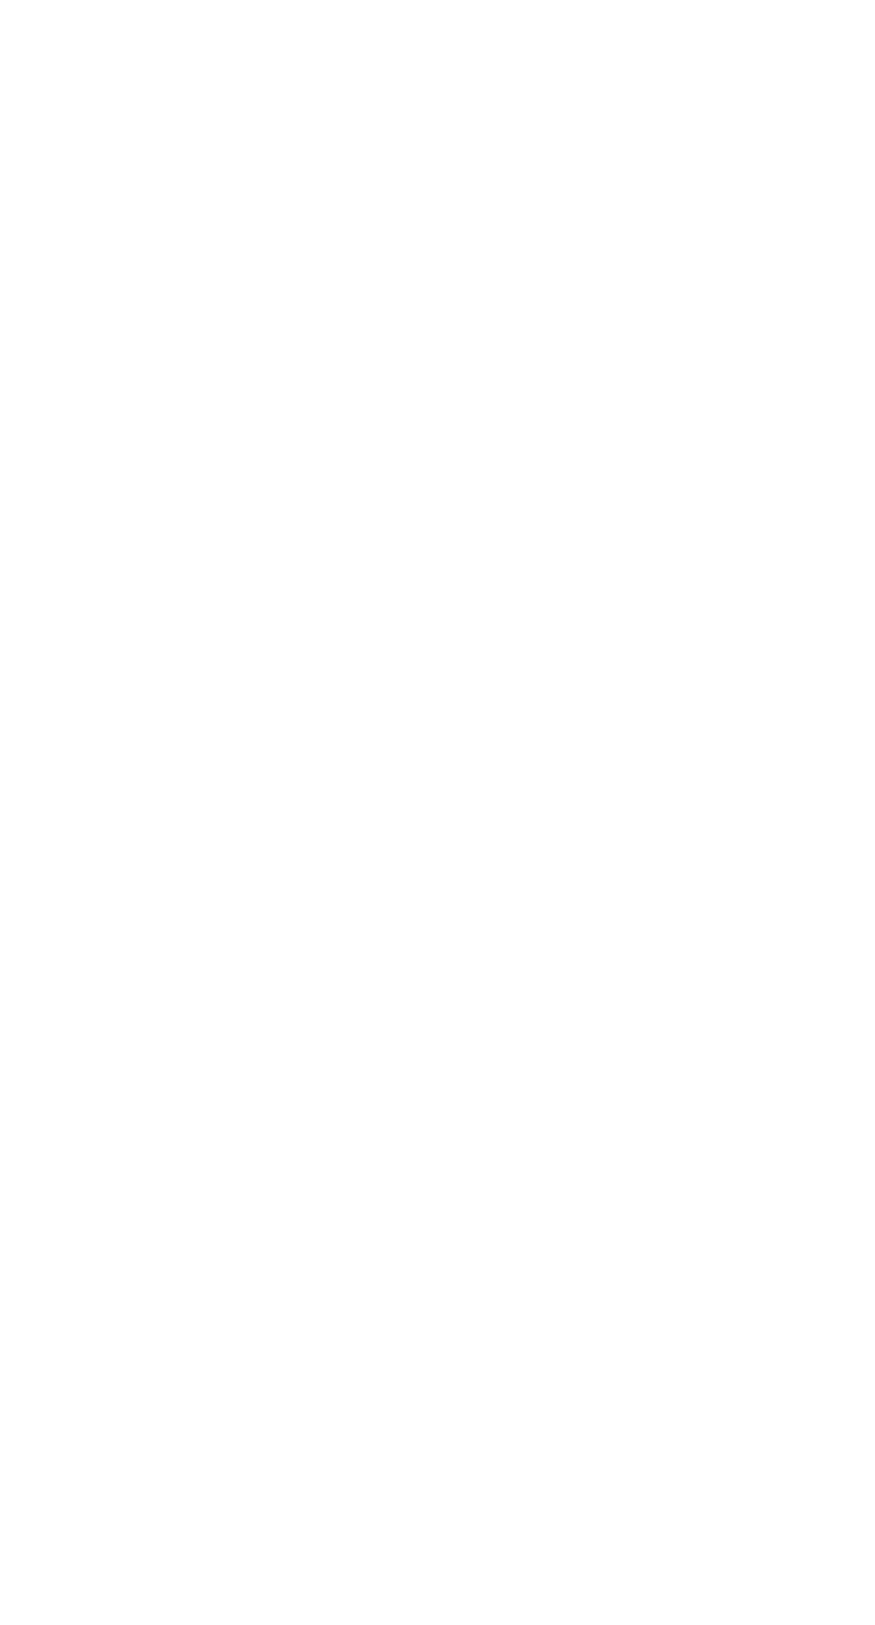

In [8]:
State = df[df['State'] != 'India'].copy()
State = State.sort_values(['State', 'Date']).set_index(['State', 'Date'])

State['Daily Count'] = State.groupby(level = 0)['Confirmed'].diff()
State['Recovery Count'] = State.groupby(level = 0)['Recovered'].diff()
State['Death Count'] = State.groupby(level = 0)['Deceased'].diff()

State = State.fillna(0)

st = ['Maharashtra', 'Tamil Nadu', 'Delhi', 'Karnataka', 'Andhra Pradesh', 'Uttar Pradesh',
     'West Bengal', 'Madhya Pradesh', 'Gujarat', 'Kerala']

%matplotlib notebook
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10)) = plt.subplots(figsize=(7, 13), nrows=5, ncols=2, sharex = True)
axs = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10]

fig.suptitle('Covid-19 States Based Time Series', fontsize = 20)

for i, ax in zip(st, axs):
    
    d = State.xs(i, drop_level = False)[:-1].reset_index()
    ax.plot(d['Date'], d['Daily Count'], alpha = 0.8, color = '#000000')
    ax.fill_between(d['Date'], d['Daily Count'], color='#00e6e6')
    
    ax.title.set_text('{}'.format(i))
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.spines['left'].set_alpha(0.5)
    ax.spines['bottom'].set_alpha(0.5)
    
    ax.tick_params(axis = 'both', which = u'both', length = 2)
    
    month = MonthLocator()
    monthFmt = DateFormatter("%b' %d")
    ax.xaxis.set_major_locator(month)
    ax.xaxis.set_major_formatter(monthFmt)
    
fig.tight_layout()
fig.subplots_adjust(top=0.888)

In [9]:
def readFile():
    dfs = []
    for i in range(1, 12):
    
        url_2 = 'https://api.covid19india.org/csv/latest/raw_data'+str(i)+'.csv'
    
        resp = requests.get(url_2).content
        
        dfs.append(pd.read_csv(io.StringIO(resp.decode('utf-8')), usecols = ['Date Announced', 'Age Bracket', 'Gender']))
        
    return pd.concat(dfs, ignore_index = True, sort = False)  

G:\SoFTWare\Anaconda\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


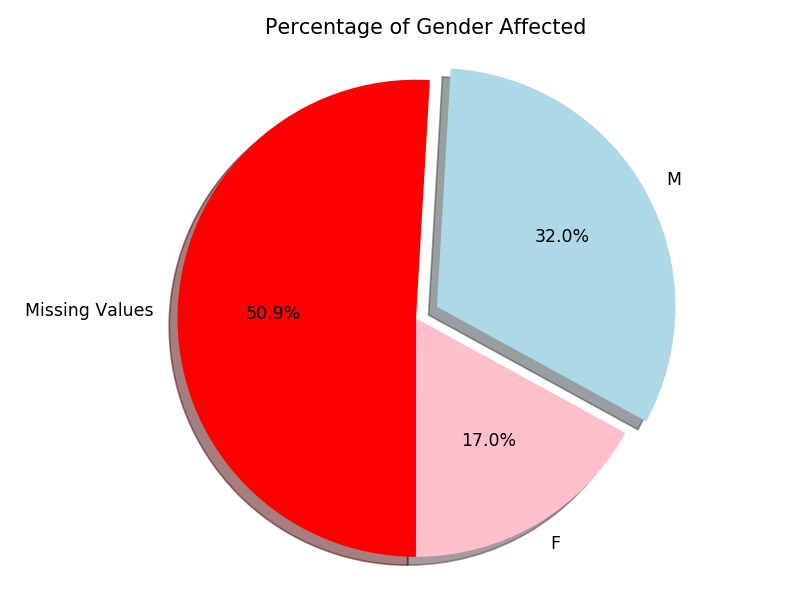

In [12]:
Gender = readFile()
Gender['Gender'] = Gender['Gender'].replace({'M ' : 'M', 'M,' : 'M'})
G_count = Gender[:-3509].fillna('Missing Values').groupby('Gender')['Gender'].agg({'Count' : len}).drop('Non-Binary')
G_count['Count'] = G_count['Count'] / len(Gender[:-3509])

%matplotlib notebook
fig, ax1 = plt.subplots()
ax1.pie(G_count['Count'], explode = (0, 0.1, 0), labels = G_count.index.tolist(), autopct='%1.1f%%',
        shadow=True, startangle=270, colors = ['pink', 'lightblue', 'red'])
ax1.axis('equal')
plt.title('Percentage of Gender Affected')

plt.show()
plt.tight_layout()

G:\SoFTWare\Anaconda\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  # Remove the CWD from sys.path while we load stuff.


<IPython.core.display.Javascript object>


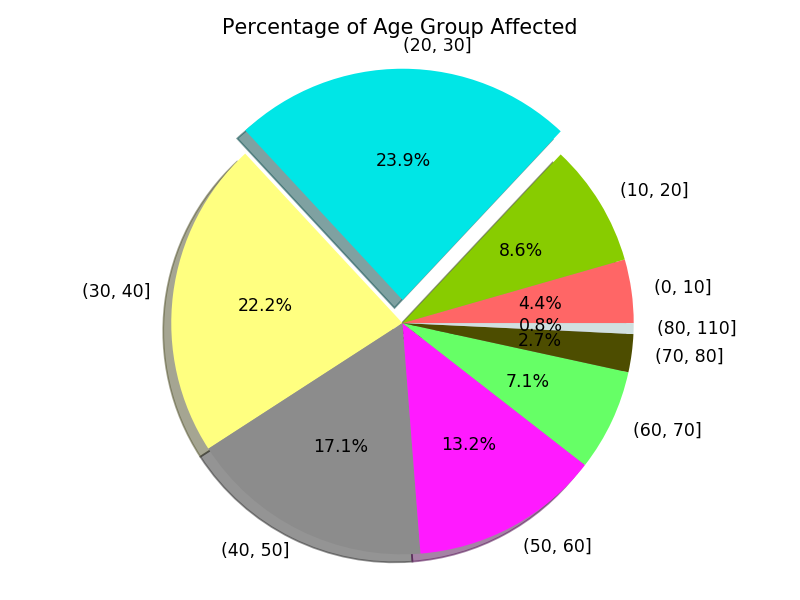

In [11]:
Age_bin = Gender.copy().drop(['Gender'], axis = 1).dropna(how = 'all')
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 110]

import re
Age_bin['Age Bracket'] = (Age_bin['Age Bracket'].replace(r'([\d{1, 2}] [\w]*)', 1, regex = True)
                          .apply(lambda s: re.sub(r'([\d]*-[\d]*)', str(s).split('-')[0], str(s)))
                          .replace('nan', 0).astype(float).round(0).astype(int))

Age_bin['binned'] = pd.cut(Age_bin['Age Bracket'], bins)
Age_bin = Age_bin.groupby('binned')['binned'].agg({'Count' : len})

Age_bin['Count'] = Age_bin['Count'] / len(Age_bin)

%matplotlib notebook
fig, ax1 = plt.subplots()
ax1.pie(Age_bin['Count'], explode = (0, 0, 0.1, 0, 0, 0, 0, 0, 0), labels = Age_bin.index.tolist(), autopct='%1.1f%%',
        shadow = True, startangle = 0, colors = ['#ff6666', '#88cc00', '#00e6e6', '#ffff80', '#8c8c8c', '#ff1aff', '#66ff66', '#4d4d00', '#d1e0e0'])
ax1.axis('equal')
plt.title('Percentage of Age Group Affected')

plt.tight_layout()